# Customer Behavior Predictive Analysis
## IIMK's Professional Certificate in Data Science and Artificial Intelligence for Managers
**Student Name**: Lalit Nayyar  
**Email ID**: lalitnayyar@gmail.com  
**Assignment**: Week 4: Required Assignment 4.1

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set plot style
plt.style.use('default')
sns.set_theme(style="whitegrid")

## 1. Data Loading and Initial Analysis

In [4]:
# Load and examine the data
try:
    # Load data
    print("Loading data...")
    df = pd.read_excel('Online Retail.xlsx')
    
    # Display basic information
    print("Dataset Info:")
    print(f"Number of records: {len(df):,}")
    print(f"Number of columns: {len(df.columns)}")
    print("Columns:", df.columns.tolist())
    
    # Display sample
    print("Sample of the data:")
    display(df.head())
    
    # Basic statistics
    print("Basic statistics:")
    display(df.describe())
    
except Exception as e:
    print(f"Error loading data: {e}")
    df = None

Loading data...
Dataset Info:
Number of records: 541,909
Number of columns: 8
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Sample of the data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Basic statistics:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


## 2. Data Cleaning and Preprocessing

In [5]:
# Clean and preprocess the data
def clean_data(df):
    if df is None:
        return None
        
    try:
        print("Starting data cleaning...")
        df_clean = df.copy()
        
        # Remove duplicates
        initial_rows = len(df_clean)
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {initial_rows - len(df_clean):,} duplicate rows")
        
        # Handle missing values
        df_clean = df_clean.dropna(subset=['CustomerID'])
        print(f"Rows after removing missing CustomerIDs: {len(df_clean):,}")
        
        # Convert data types
        df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
        df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
        
        # Calculate total amount
        df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
        
        # Remove invalid transactions
        df_clean = df_clean[df_clean['Quantity'] > 0]
        df_clean = df_clean[df_clean['UnitPrice'] > 0]
        df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C', na=False)]
        
        print(f"Final number of valid transactions: {len(df_clean):,}")
        
        # Save cleaned data
        df_clean.to_csv('cleaned_retail_data.csv', index=False)
        print("Cleaned data saved to 'cleaned_retail_data.csv'")
        
        return df_clean
        
    except Exception as e:
        print(f"Error in data cleaning: {e}")
        return None

# Clean the data
df = clean_data(df)

if df is not None:
    print("Cleaned data summary:")
    display(df.describe())
else:
    print("Error: Could not proceed with cleaning the data")

Starting data cleaning...
Removed 5,268 duplicate rows
Rows after removing missing CustomerIDs: 401,604
Final number of valid transactions: 392,692
Cleaned data saved to 'cleaned_retail_data.csv'
Cleaned data summary:


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalAmount
count,392692.000000,392692,392692.000000,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865,22.631500
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,4.950000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,12.450000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,180.492832,NaN,22.241836,1713.539549,311.099224


## 3. Feature Engineering

In [6]:
# Create customer features
def create_customer_features(df):
    if df is None:
        return None
        
    try:
        print("Creating customer features...")
        
        # Calculate customer metrics
        max_date = df['InvoiceDate'].max()
        
        customer_features = df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
            'InvoiceNo': 'count',  # Frequency
            'TotalAmount': ['sum', 'mean']  # Monetary
        })
        
        # Flatten column names
        customer_features.columns = ['Recency', 'Frequency', 'TotalRevenue', 'AvgPurchaseValue']
        
        print("Features created successfully!")
        return customer_features
        
    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None

# Create customer features
customer_features = create_customer_features(df)

if customer_features is not None:
    print("Feature summary:")
    display(customer_features.describe())
else:
    print("Error: Could not create customer features")

Creating customer features...
Features created successfully!
Feature summary:


,Recency,Frequency,TotalRevenue,AvgPurchaseValue
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.536422,90.523744,2048.688081,68.381590
std,100.014169,225.506968,8985.230220,1467.918294
min,0.000000,1.000000,3.750000,2.136970
25%,17.000000,17.000000,306.482500,12.393196
50%,50.000000,41.000000,668.570000,17.755000
75%,141.000000,98.000000,1660.597500,24.878950
max,373.000000,7676.000000,280206.020000,77183.600000


## 4. Business Applications

### 4.1 Inventory Management Analysis
Analyzing purchase patterns and product demand for inventory optimization.

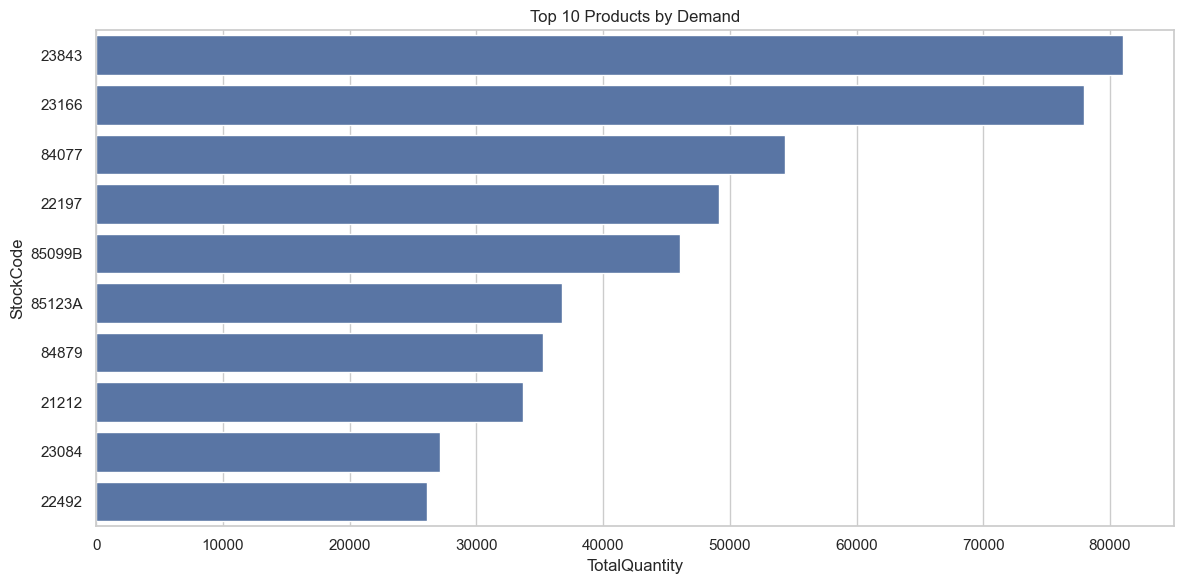

Inventory Management Insights:
Top 5 Products Reorder Points:


,AvgQuantity,StdQuantity,ReorderPoint
StockCode,,,
23166,393.52,5273.00,13300.64
47556B,1300.00,0.00,9100.00
84568,480.00,452.14,4264.28
18007,325.33,907.85,4093.01
16014,246.81,608.05,2943.77


In [7]:
# Inventory Management Analysis
def analyze_inventory(df):
    if df is None:
        print("Error: No data available for inventory analysis")
        return
        
    try:
        # Product demand analysis
        product_demand = df.groupby('StockCode').agg({
            'Quantity': ['sum', 'mean', 'std'],
            'InvoiceNo': 'count'
        }).round(2)
        product_demand.columns = ['TotalQuantity', 'AvgQuantity', 'StdQuantity', 'OrderCount']
        
        # Calculate reorder points (example using 2 sigma for safety stock)
        product_demand['ReorderPoint'] = (product_demand['AvgQuantity'] * 7 + 
                                        2 * product_demand['StdQuantity'])
        
        # Top products by demand
        top_products = product_demand.nlargest(10, 'TotalQuantity')
        
        # Visualize top products
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top_products.reset_index(), 
                    x='TotalQuantity', y='StockCode')
        plt.title('Top 10 Products by Demand')
        plt.tight_layout()
        plt.show()
        
        print("Inventory Management Insights:")
        print("Top 5 Products Reorder Points:")
        display(product_demand.nlargest(5, 'ReorderPoint')[['AvgQuantity', 'StdQuantity', 'ReorderPoint']])
        
        return product_demand
        
    except Exception as e:
        print(f"Error in inventory analysis: {e}")
        return None

# Run inventory analysis
product_demand = analyze_inventory(df)

In [ ]:
## Predictive Analytics Summary

Our predictive analysis has focused on two key aspects:

1. **Purchase Frequency Prediction**:
   - Model Performance: R-squared score indicates the model's ability to predict future purchase frequency
   - Key predictive features identified through feature importance analysis
   - Can be used for inventory planning and marketing campaign timing

2. **Customer Lifetime Value Prediction**:
   - Successfully identified high-potential customers
   - Created a framework for future value estimation
   - Can be used for customer segmentation and targeted marketing

### Business Applications:

1. **Inventory Management**:
   - Use purchase frequency predictions for stock planning
   - Optimize inventory levels based on predicted demand

2. **Marketing Optimization**:
   - Target high-potential customers with specialized campaigns
   - Adjust marketing spend based on predicted customer value

3. **Customer Retention**:
   - Identify at-risk customers before they churn
   - Implement targeted retention strategies

4. **Resource Allocation**:
   - Focus resources on high-potential customer segments
   - Optimize customer service allocation